# PIPELINE

In [1]:
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import numpy as np 
import os

import vip_hci as vip
from vip_hci.fits import open_fits
from main import (shift_and_crop_cube, 
                  fit_and_crop, 
                  frame_center, 
                  get_square, 
                  fit_gaussian_2d, 
                  recenter_cube, 
                  normalize_psf)
from vip.pca import reduce_pca
from vip.detection import get_intersting_coords
from vip.loss import inject_fcs_cube_mod

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

%load_ext autoreload
%autoreload 2

2023-05-12 16:14:19.489318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 16:14:20.363915: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/users/cdonoso/miniconda3/envs/tf2/lib/python3.9/site-packages/cv2/../../lib64:
2023-05-12 16:14:20.363995: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/users/cdonoso/miniconda3/envs/tf2/lib/p

## LOADING DATA

In [2]:
root = './data/HCI'
cube_route = os.path.join(root, 'center_im.fits')
cube       = open_fits(cube_route, header=False) 

psf_route = os.path.join(root, 'median_unsat.fits')
psf       = open_fits(psf_route, header=False)

ra_route = os.path.join(root, 'rotnth.fits')
rot_ang  = open_fits(ra_route, header=False)
rot_ang  = -rot_ang

# lam_route   = os.path.join(root, 'lam.fits')
# lambdas_inf = open_fits(lam_route, header=False)

lambda_ch = 0 # channel to use
psf_pos   = 0 # psf position

Fits HDU-0 data successfully loaded. Data shape: (2, 90, 201, 201)
Fits HDU-0 data successfully loaded. Data shape: (2, 2, 64, 64)
Fits HDU-0 data successfully loaded. Data shape: (90,)


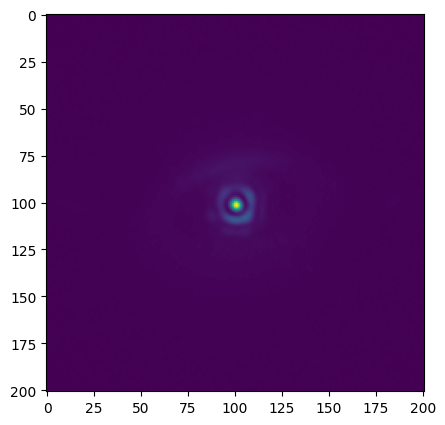

In [3]:
plt.figure(figsize=(5,5), dpi=100)
plt.imshow(cube[0, 0])

In [4]:
def modify_shape_and_center(img, shift_h=1, shift_w=1):
    # Get the height and width of the image
    height, width = img.shape[:2]

    # Increase the image size by 1 pixel
    new_height = height + shift_h
    new_width = width + shift_w

    # Create a new image with the increased size
    new_img = np.zeros((new_height, new_width))

    # Calculate the offset needed to center the original image in the new image
    x_offset = int((new_width - width) / 2)
    y_offset = int((new_height - height) / 2)

    # Copy the original image into the center of the new image
    new_img[y_offset:y_offset+height, x_offset:x_offset+width] = img

    return new_img

In [5]:
psf_even = []
for curr_psf in psf[lambda_ch]:
    psf_even.append(modify_shape_and_center(curr_psf, shift_h=1, shift_w=1)) 
psf_even = np.array(psf_even)

Text(0.5, 1.0, '(2, 65, 65)')

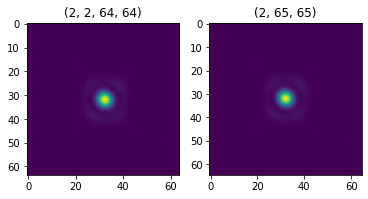

In [6]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(psf[lambda_ch, 0])
axes[0].set_title(psf.shape)

im = axes[1].imshow(psf_even[0])
axes[1].set_title(psf_even.shape)

## Normalize PSF

In [7]:
psf[lambda_ch].shape

(2, 64, 64)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-05-12 16:14:21
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
`subi_size` is odd (while frame size is even)
Setting `subi_size` to 8 pixels
Shifting
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Running time:  0:00:00.202242
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


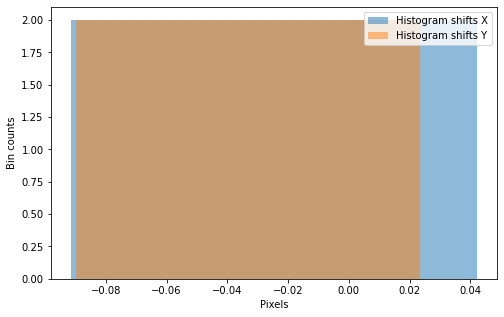

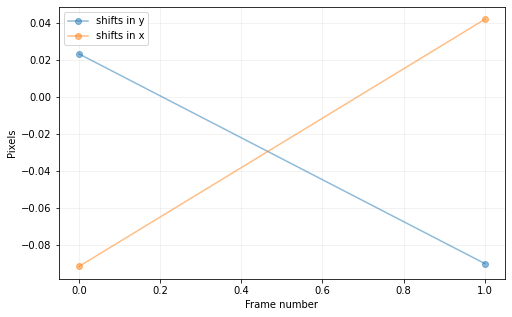

In [8]:
single_psf = psf[lambda_ch, psf_pos, :-1, :-1]
ceny, cenx = frame_center(single_psf)
imside = single_psf.shape[0]
cropsize = 30

fit = vip.var.fit_2dgaussian(single_psf, 
                             crop=True, 
                             cropsize=30, 
                             debug=False, 
                             full_output=True) 
fwhm_sphere = np.mean([fit.fwhm_y,fit.fwhm_x]) 

y_cent, x_cent = frame_center(single_psf) 
y_c=int(y_cent)
x_c=int(x_cent)
psf_center, y0_sh = vip.preproc.recentering.cube_recenter_2dfit(psf[lambda_ch], (y_c, x_c), 
                                                                       fwhm_sphere,model='gauss',
                                                                       nproc=8, subi_size=7, negative=False,
                                                                       full_output=False, 
                                                                       debug=False)

In [9]:
psf_norm, fwhm_flux, fwhm = normalize_psf(psf_center, 
                                         fwhm=fwhm_sphere, 
                                         size=None, 
                                         threshold=None, 
                                         mask_core=None,
                                         full_output=True, 
                                         verbose=True) 

`Force_odd` is True and frame size is even, therefore new frame size was set to 63
Flux in 1xFWHM aperture: 130696.559


## Angular Differential Imaging (ADI)

In [10]:
%%time
fr_pca = vip.psfsub.pca(cube[0], 
                            rot_ang,
                            svd_mode='eigencupy', 
                            full_output=False,
                            imlib='opencv') #pca image of the system

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-05-12 16:14:21
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 270.406 GB
System available memory = 219.087 GB
Done vectorizing the frames. Matrix shape: (90, 40401)
Done PCA with cupy eigh function (GPU)
Running time:  0:00:02.750895
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done de-rotating and combining
Running time:  0:00:03.066914
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
CPU times: user 2.15 s, sys: 889 ms, total: 3.04 s
Wall time: 3.07 s


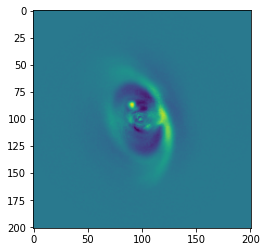

In [11]:
plt.imshow(fr_pca)

## Detection

In [12]:
res = vip.metrics.detection(fr_pca, fwhm=fwhm, psf=psf_norm, bkg_sigma=5, snr_thresh=2, 
                            debug=False, plot=False, verbose=True, full_output=True)

Blobs found: 2
 ycen   xcen
------ ------
87.124 	 90.708
99.917 	 89.227

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
X,Y = (90.7,87.1)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Coords of chosen px (X,Y) = 90.7, 87.1
Flux in a centered 1xFWHM circular aperture = 47.294
Central pixel S/N = 2.607
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 1.983
Max S/N (shifting the aperture center) = 2.624
stddev S/N (shifting the aperture center) = 0.410


――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
X,Y = (89.2,99.9)
S/N constraint NOT fulfilled (S/N = 1.370)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [13]:
res

,y,x,px_snr
0,87.124295,90.707752,2.60706


## Optimizing

In [14]:
%%time
results = vip.fm.negfc_simplex.firstguess(cube[0], 
                                          angs=rot_ang,       
                                          psfn=psf_norm, 
                                          ncomp=2, 
                                          planets_xy_coord=[(res.iloc[0]['y'], res.iloc[0]['x'])],
                                          imlib='opencv',
                                          fwhm=fwhm,
                                          simplex=False,
                                          annulus_width=4*fwhm,
                                          aperture_radius=2,
                                         algo_options={
                                             'nproc': 32,
                                             'imlib': 'opencv'
                                         })

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-05-12 16:14:33
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [87.12429465591156,90.70775238923589], running ...
Step | flux    | chi2r
1/30   0.100   0.161
2/30   0.149   0.161
3/30   0.221   0.162
4/30   0.329   0.162
Planet 0: preliminary position guess: (r, theta)=(15.9, 215.8)
Planet 0: preliminary flux guess: 0.1
Planet 0: Simplex Nelder-Mead minimization skipped.
Planet 0: simplex result: (r, theta, f)=(15.879, 215.818, 0.100) at 
          (X,Y)=(87.12, 90.71)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

In [15]:
radius_fguess = results[0][0]
theta_fguess  = results[1][0]
flux_fguess   = results[2][0]

In [16]:
centy_fr, centx_fr = frame_center(cube[0])
posy = radius_fguess * np.sin(np.deg2rad(theta_fguess)) + centy_fr
posx = radius_fguess * np.cos(np.deg2rad(theta_fguess)) + centx_fr
posx,posy

(87.12429465591156, 90.70775238923589)

(27.124294655911555, 147.12429465591157)

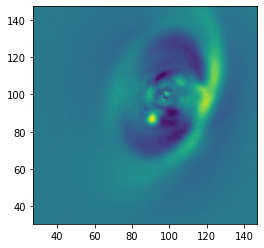

In [17]:
plt.figure()
plt.imshow(fr_pca)
plt.scatter(posx, posy, marker='x')
plt.ylim(posy-60, posx+60)
plt.xlim(posx-60, posx+60)

## Visualizing results

In [76]:
from vip_hci.fm.negfc_fmerit import cube_inject_companions

In [71]:
cube_negfc = cube_inject_companions(np.zeros_like(cube[0]), psf_norm, rot_ang, flevel=flux_fguess,
                                    rad_dists=[radius_fguess], n_branches=1,
                                    theta=theta_fguess)

adi_fake = reduce_pca(cube_negfc, rot_angles=rot_ang)

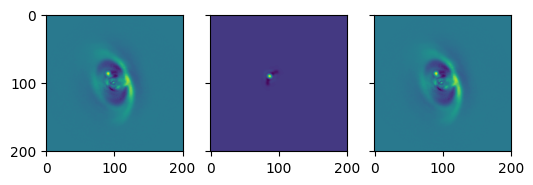

In [74]:
fig, axes = plt.subplots(1, 3, dpi=100, sharex=True, sharey=True)
axes[0].imshow(fr_pca)
axes[1].imshow(adi_fake)
axes[2].imshow(fr_pca-adi_fake)

### MCMC

In [94]:
from vip_hci.fm.negfc_mcmc import mcmc_negfc_sampling
from multiprocessing import cpu_count
from vip_hci.psfsub import pca_annulus

In [98]:
obs_params = {'psfn': psf_norm, 'fwhm': 4.}

algo_params = {'algo': pca_annulus,
               'ncomp': 1,
               'annulus_width': obs_params['fwhm']*2,
               'svd_mode': 'lapack',
               'imlib': 'opencv',
               'interpolation': 'lanczos4'}

mu_sigma=True
aperture_radius=2

negfc_params = {'mu_sigma': mu_sigma,
                'aperture_radius': aperture_radius}

nwalkers, itermin, itermax = (100, 200, 500)

mcmc_params = {'nwalkers': nwalkers,
               'niteration_min': itermin,
               'niteration_limit': itermax,
               'bounds': None,
               'nproc': cpu_count()//2}

conv_test, ac_c, ac_count_thr, check_maxgap = ('ac', 50, 1, 50)

conv_params = {'conv_test': conv_test,
               'ac_c': ac_c,
               'ac_count_thr': ac_count_thr,
               'check_maxgap': check_maxgap}

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-05-12 16:46:07
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
        MCMC sampler for the NEGFC technique       
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
The mean and stddev in the annulus at the radius of the companion (excluding the PA area directly adjacent to it) are -0.13 and 3.31 respectively.
Beginning emcee Ensemble sampler...
emcee Ensemble sampler successful

Start of the MCMC run ...
Step  |  Duration/step (sec)  |  Remaining Estimated Time (sec)
0		1.95197			974.03528
1		1.99679			994.40341
2		2.05231			1019.99757
3		2.01508			999.47770
4		2.06659			1022.96007
5		1.99578			985.91631
6		2.04071			1006.06855
7		2.01737			992.54702
8		2.02962			996.54244
9		1.99850			979.26353
10		2.03866			996.90523
11		2.04179			996.39206
12		1.98534			966.85815
13		1.87996			913.65862
14		1.87969			911.64965
15		1.844

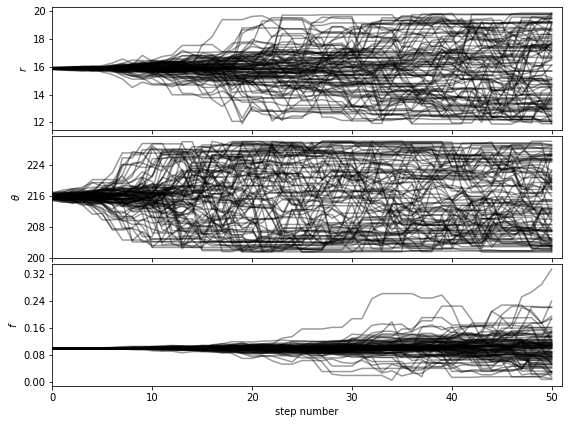

51		2.32045			1039.56205
52		1.73330			774.78555
53		1.71493			764.86056
54		1.75350			780.30661
55		1.72436			765.61628
56		1.70373			754.75283
57		1.72834			763.92584
58		1.84064			811.72180
59		1.72753			760.11232
60		1.62761			714.52211
61		1.75575			769.01762
62		1.81141			791.58704
63		1.72029			750.04775
64		1.79369			780.25645
65		1.76018			763.91725
66		1.80385			781.06662
67		1.73401			749.09318
68		1.76662			761.41322
69		1.74912			752.12117
70		1.78771			766.92545
71		1.80045			770.59132
72		1.73445			740.61143
73		1.72552			735.07067
74		1.79961			764.83340
75		1.75610			744.58810
76		1.75654			743.01811
77		1.74481			736.31109
78		1.81014			762.07062
79		1.76713			742.19544
80		1.68709			706.89071
81		1.80965			756.43537
82		1.73618			723.98664
83		1.78605			742.99638
84		1.76365			731.91309
85		1.83455			759.50577
86		1.73426			716.25062
87		1.79337			738.86844
88		1.74988			719.20150
89		1.79235			734.86350
90		1.68808			690.42431
91		1.69451			691.36130
92		1.73481			7

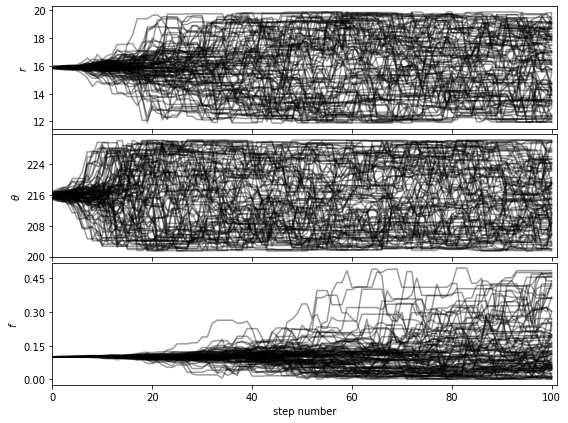

101		2.30201			916.19918
102		1.76576			701.00513
103		1.79892			712.37311
104		1.74368			688.75558
105		1.79699			708.01445
106		1.80368			708.84624
107		1.79033			701.80975
108		1.79665			702.49054
109		1.77613			692.69070
110		1.78965			696.17463
111		1.80960			702.12402
112		1.79257			693.72343
113		1.71022			660.14338
114		1.73343			667.37055
115		1.69721			651.72941
116		1.82643			699.52231
117		1.77589			678.38998
118		1.75680			669.33966
119		1.78077			676.69108
120		1.73764			658.56556
121		1.69623			641.17570
122		1.79240			675.73631
123		1.75902			661.39077
124		1.69609			636.03300
125		1.86928			699.11147
126		1.80926			674.85323
127		1.70424			633.97691
128		1.71913			637.79723
129		1.74537			645.78616
130		1.75612			648.00939
131		1.78847			658.15659
132		1.75825			645.27922
133		1.80372			660.16298
134		1.73916			634.79157
135		1.83501			667.94400
136		1.76069			639.13083
137		1.79857			651.08125
138		1.73962			628.00318
139		1.80558			650.00880
140		1.71520			615.75572


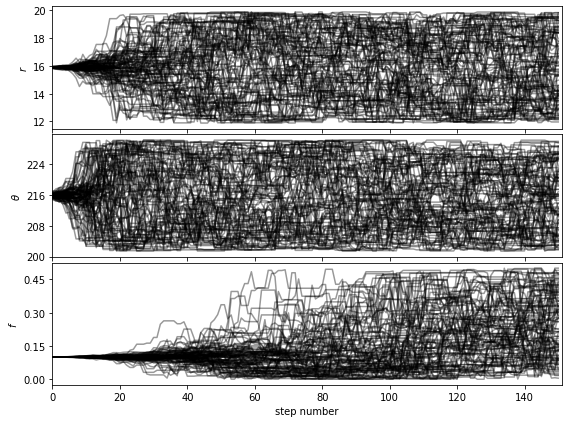

151		2.22083			772.85023
152		1.71642			595.59739
153		1.71813			594.47333
154		1.72686			595.76635
155		1.78289			613.31313
156		1.85826			637.38455
157		1.69439			579.48138
158		1.77904			606.65128
159		1.76064			598.61828
160		1.72210			583.79326
161		1.76489			596.53316
162		1.80656			608.81005
163		1.83244			615.69984
164		1.80791			605.65085
165		1.80347			602.35865
166		1.73780			578.68807
167		1.81096			601.23972
168		1.78412			590.54538
169		1.81888			600.23106
170		1.74546			574.25502
171		1.76778			579.83315
172		1.76080			575.78127
173		1.83389			597.84879
174		1.72149			559.48587
175		1.77508			575.12462
176		1.68621			544.64583
177		1.77623			571.94735
178		1.73293			556.26925
179		1.78378			570.81120
180		1.84315			587.96485
181		1.78839			568.70770
182		1.78518			565.90269
183		1.83459			579.73202
184		1.78066			560.90727
185		1.86687			586.19687
186		1.78235			557.87461
187		1.84387			575.28713
188		1.77072			550.69361
189		1.83687			569.42908
190		1.73093			534.85891


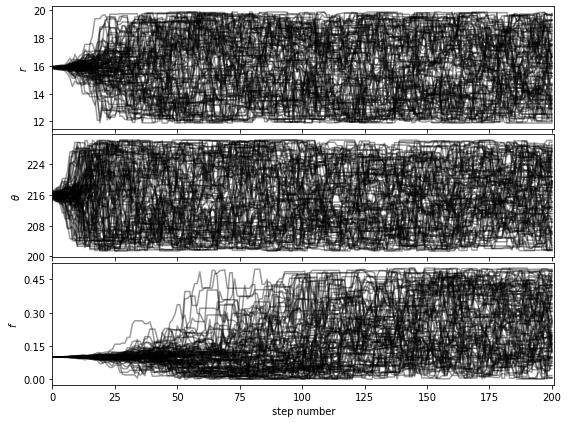

Auto-corr tau/N = [0.08269035 0.08067319 0.10005287]
tau/N <= 0.02 = [False False False] 

201		2.38882			711.86717
202		1.69108			502.25017
203		1.76655			522.89821
204		1.72254			508.15018
205		1.80720			531.31651
206		1.75123			513.10892
207		1.80385			526.72537
208		1.74325			507.28691
209		1.77709			515.35494
210		1.80127			520.56819
211		1.80188			518.94115
212		1.81119			519.81067
213		1.76055			503.51787
214		1.80265			513.75667
215		1.70701			484.79141
216		1.72122			487.10469
217		1.78964			504.67848
218		1.76320			495.46032
219		1.81678			508.69756
220		1.75884			490.71608
221		1.74791			485.91898
222		1.78025			493.12787
223		1.70354			470.17649
224		1.73952			478.36690
225		1.82160			499.11950
226		1.83323			500.47261
227		1.76903			481.17698
228		1.79506			486.46261
229		1.76805			477.37350
230		1.84299			495.76297
231		1.73564			465.15232
232		1.68152			448.96691
233		1.84001			489.44319
234		1.72980			458.39594
235		1.71915			453.85534
236		1.79220			471.34781
237		1.80

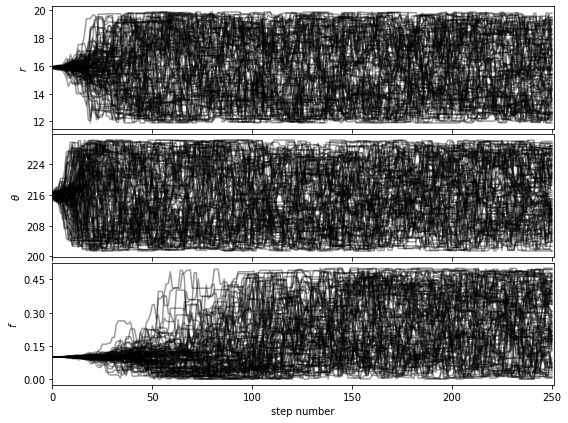

Auto-corr tau/N = [0.07616201 0.08046014 0.09880735]
tau/N <= 0.02 = [False False False] 

251		2.29202			568.42170
252		1.77020			437.23940
253		1.73565			426.97015
254		1.80640			442.56824
255		1.72541			420.99931
256		1.74763			424.67506
257		1.82560			441.79496
258		1.71946			414.39034
259		1.82786			438.68688
260		1.80474			431.33382
261		1.75996			418.87119
262		1.74531			413.63894
263		1.73121			408.56462
264		1.79697			422.28913
265		1.80517			422.40908
266		1.74218			405.92887
267		1.71685			398.30850
268		1.72670			398.86793
269		1.77039			407.18947
270		1.76549			404.29767
271		1.74557			397.99064
272		1.82179			413.54610
273		1.80284			407.44139
274		1.78306			401.18805
275		1.86777			418.37981
276		1.71256			381.90133
277		1.78181			395.56271
278		1.85811			410.64319
279		1.74838			384.64250
280		1.80281			394.81539
281		1.77981			387.99749
282		1.73822			377.19266
283		1.74912			377.80949
284		1.78693			384.19102
285		1.73828			371.99106
286		1.73956			370.52671
287		1.75

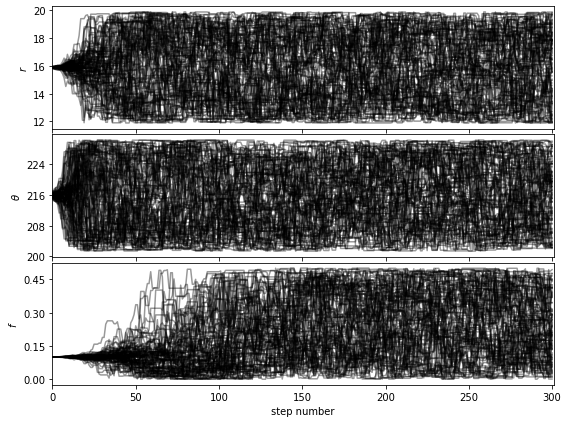

Auto-corr tau/N = [0.07253142 0.075998   0.0939053 ]
tau/N <= 0.02 = [False False False] 

301		2.35647			466.58086
302		1.74420			343.60661
303		1.79347			351.52110
304		1.77682			346.48048
305		1.77406			344.16783
306		1.81788			350.85045
307		1.81251			348.00250
308		1.77790			339.57966
309		1.67246			317.76664
310		1.78840			338.00722
311		1.83613			345.19150
312		1.77659			332.22158
313		1.83189			340.73154
314		1.75107			323.94721
315		1.63977			301.71842
316		1.85465			339.40113
317		1.80148			327.87009
318		1.79345			324.61391
319		1.77232			319.01742
320		1.76332			315.63392
321		1.78892			318.42812
322		1.74778			309.35618
323		1.74019			306.27256
324		1.68693			295.21292
325		1.73062			301.12805
326		1.71725			297.08373
327		1.75232			301.39835
328		1.71721			293.64206
329		1.75135			297.72950
330		1.75245			296.16337
331		1.75570			294.95827
332		1.74223			290.95174
333		1.76682			293.29245
334		1.75382			289.37980
335		1.83768			301.37952
336		1.81512			295.86472
337		1.77

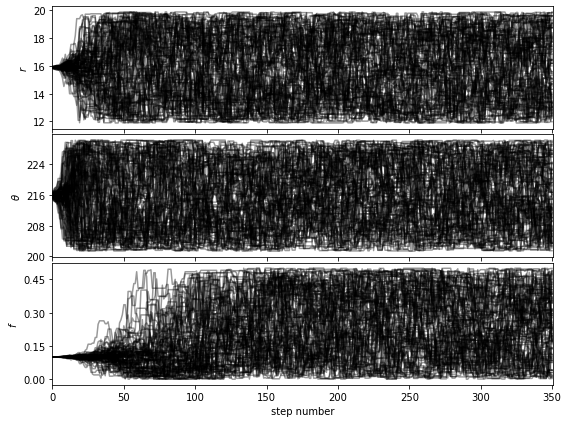

Auto-corr tau/N = [0.06954857 0.07174525 0.0868547 ]
tau/N <= 0.02 = [False False False] 

351		2.37834			351.99491
352		1.76795			259.88850
353		1.82810			266.90318
354		1.73325			251.32154
355		1.74696			251.56282
356		1.75440			250.87992
357		1.74444			247.71005
358		1.84101			259.58283
359		1.76956			247.73840
360		1.77804			247.14686
361		1.68691			232.79317
362		1.79936			246.51232
363		1.76413			239.92209
364		1.85315			250.17525
365		1.77945			238.44630
366		1.76974			235.37569
367		1.75336			231.44405
368		1.71910			225.20145
369		1.77324			230.52081
370		1.76697			227.93926
371		1.74464			223.31443
372		1.80627			229.39604
373		1.87913			236.77038
374		1.76968			221.20950
375		1.72430			213.81370
376		1.86608			229.52846
377		1.72495			210.44427
378		1.72562			208.80026
379		1.75178			210.21408
380		1.77729			211.49775
381		1.76583			208.36841
382		1.75829			205.71958
383		1.73824			201.63561
384		1.78942			205.78376
385		1.78107			203.04175
386		1.77565			200.64834
387		1.80

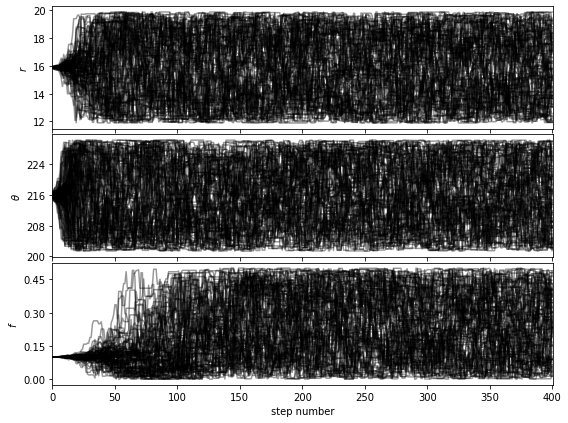

Auto-corr tau/N = [0.0659137  0.06832754 0.07937359]
tau/N <= 0.02 = [False False False] 

401		2.35255			230.55029
402		1.69987			164.88768
403		1.78355			171.22070
404		1.74860			166.11662
405		1.72358			162.01699
406		1.72970			160.86173
407		1.77433			163.23808
408		1.77378			161.41407
409		1.85427			166.88448
410		1.79993			160.19368
411		1.80296			158.66030
412		1.76944			153.94119
413		1.76544			151.82827
414		1.74595			148.40575
415		1.70283			143.03797
416		1.86816			155.05753
417		1.75000			143.49975
418		1.78101			144.26165
419		1.77765			142.21232
420		1.73188			136.81813
421		1.77292			138.28753
422		1.69059			130.17512
423		1.77584			134.96369
424		1.78089			133.56645
425		1.80559			133.61351
426		1.74671			127.51012
427		1.79328			129.11638
428		1.79938			127.75570
429		1.76416			123.49134
430		1.80633			124.63677
431		1.85410			126.07860
432		1.82917			122.55419
433		1.82472			120.43119
434		1.87263			121.72075
435		1.74598			111.74240
436		1.83112			115.36069
437		1.87

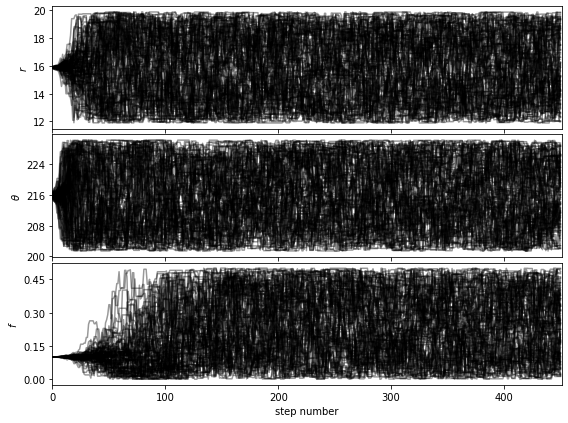

Auto-corr tau/N = [0.06326246 0.06391245 0.07633102]
tau/N <= 0.02 = [False False False] 

451		2.92250			140.27986
452		1.72945			81.28424
453		1.87261			86.14011
454		1.71247			77.06128
455		1.77542			78.11844
456		1.76270			75.79614
457		1.74965			73.48547
458		1.76180			72.23364
459		1.78426			71.37056
460		1.77610			69.26774
461		1.66969			63.44822
462		1.84948			68.43072
463		1.83200			65.95207
464		1.71095			59.88325
465		1.72789			58.74816
466		1.77043			58.42426
467		1.78807			57.21827
468		1.74197			54.00113
469		1.78118			53.43540
470		1.74067			50.47949
471		1.83922			51.49824
472		1.77086			47.81330
473		1.84654			48.00991
474		1.78548			44.63700
475		1.71808			41.23387
476		1.76516			40.59870
477		1.75319			38.57025
478		1.82782			38.38426
479		1.79573			35.91450
480		1.84115			34.98179
481		1.76503			31.77045
482		1.73628			29.51676
483		1.75974			28.15589
484		1.76870			26.53053
485		1.90678			26.69499
486		1.78558			23.21258
487		1.75553			21.06631
488		1.82268			20.04

In [99]:
initial_state = [radius_fguess, theta_fguess, flux_fguess]
chain = mcmc_negfc_sampling(cube[0], rot_ang, **obs_params, **algo_params, **negfc_params,
                            initial_state=initial_state, **mcmc_params, **conv_params,
                            display=True, verbosity=2, save=False, output_dir='./')

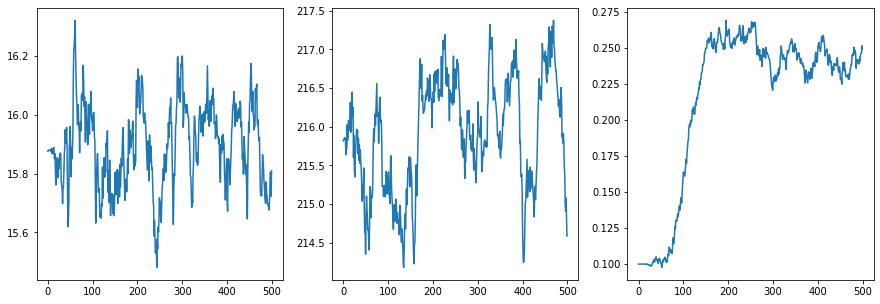

In [111]:
xm = np.mean(chain, 0)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot(xm[:, 0])
axes[1].plot(xm[:, 1])
axes[2].plot(xm[:, 2])

In [126]:
radius_star = np.mean(xm[:, 0])
theta_star  = np.mean(xm[:, 1])
flux_star   = np.mean(xm[300:, 2])

centy_fr, centx_fr = frame_center(cube[0])
posy_star = radius_star * np.sin(np.deg2rad(theta_star)) + centy_fr
posx_star = radius_star * np.cos(np.deg2rad(theta_star)) + centx_fr

In [123]:
cube_negfc = cube_inject_companions(np.zeros_like(cube[0]), psf_norm, rot_ang, flevel=-flux_star,
                                    rad_dists=[radius_star], n_branches=1,
                                    theta=theta_star)

adi_fake = reduce_pca(cube_negfc, rot_angles=rot_ang)

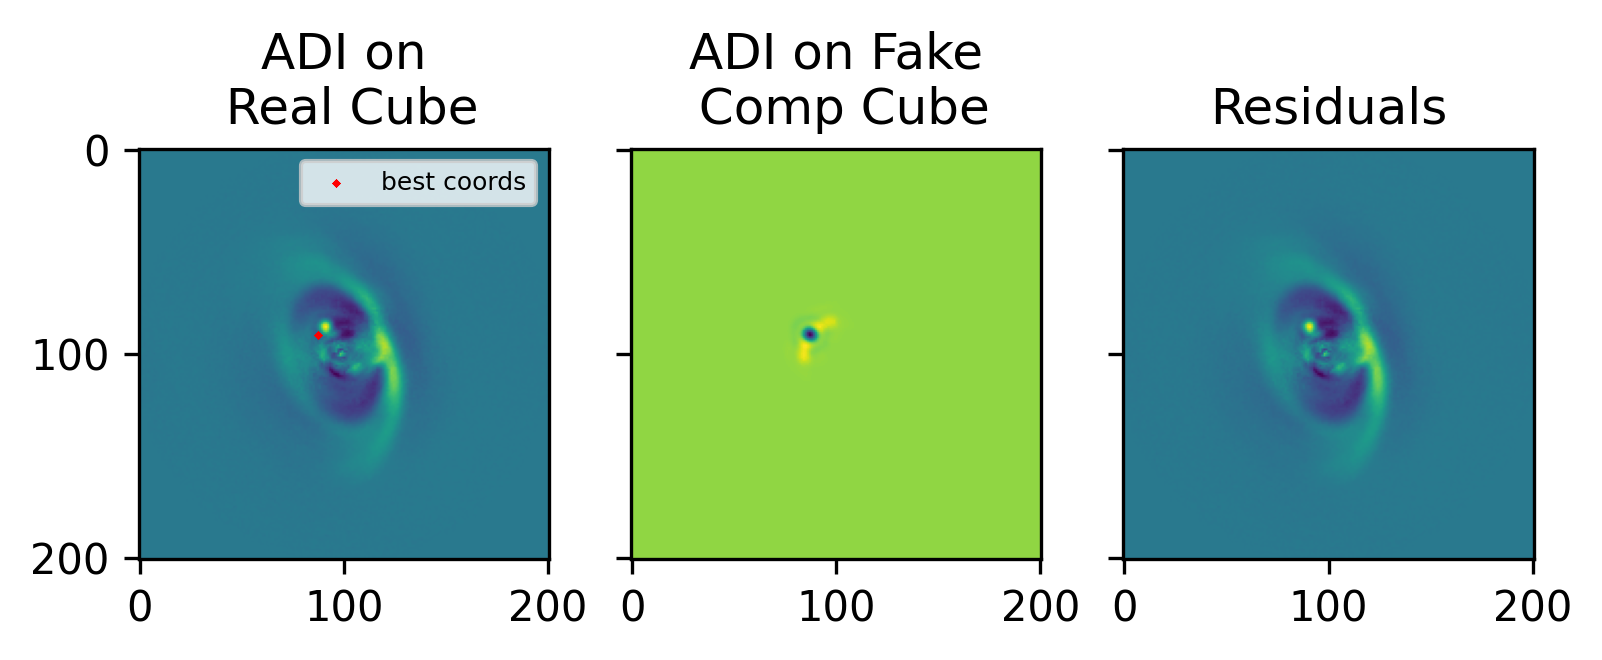

In [150]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, dpi=300)
axes[0].imshow(fr_pca)
axes[1].imshow(adi_fake)
axes[1].set_title('ADI on Fake\n Comp Cube')
axes[2].imshow(fr_pca+adi_fake)
axes[2].set_title('Residuals')
axes[0].scatter(posx_star, posy_star, marker='x', s=1, color='r', label='best coords')
axes[0].legend(bbox_to_anchor=(1., 1.), fontsize=6)
axes[0].set_title('ADI on\n Real Cube')
plt.show()